In [48]:
import os
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
import numpy as np
import opendatasets as od
import pandas
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras import layers, Model

In [3]:
od.download("https://www.kaggle.com/datasets/gonzajl/tumores-cerebrales-mri-dataset")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username:

  gonzajl


Your Kaggle Key:

  ········


100%|██████████| 639M/639M [00:05<00:00, 122MB/s]  


In [49]:
datos = pandas.read_csv("./tumores-cerebrales-mri-dataset/datos.csv")

In [50]:
# Mezcla la información en el dataset
datos = datos.sample(frac=1).reset_index(drop=True)

In [51]:
def cargar_imagenes(nombres, et):
    imagenes = []
    etiquetas = []
    for i in range(len(nombres)):
        ruta = 'tumores-cerebrales-mri-dataset/' + nombres[i][2:]
        imagen = cv2.imread(ruta, cv2.IMREAD_COLOR)
        imagenes.append(imagen)
        etiquetas.append(list(et.iloc[i]))
    return imagenes, etiquetas

In [52]:
paths = datos.iloc[:, 0]
tags = datos.iloc[:, 1:]

In [53]:
imagenes, etiquetas = cargar_imagenes(paths, tags)

In [54]:
imagenes_entrenamiento, imagenes_prueba = imagenes[:8800], imagenes[8800:11000]
etiquetas_entrenamiento, etiquetas_prueba = etiquetas[:8800], etiquetas[8800:11000]

In [55]:
def mostrar_grafico_clases(etiquetas):
    cant_glioma = etiquetas.count([1, 0, 0, 0])
    cant_meningioma = etiquetas.count([0, 1, 0, 0])
    cant_pituitary = etiquetas.count([0, 0, 1, 0])
    cant_no_tumor = etiquetas.count([0, 0, 0, 1])

    categorias = ['glioma', 'meningioma', 'pituitary', 'no_tumor']
    cantidades = [cant_glioma, cant_meningioma, cant_pituitary, cant_no_tumor]

    plt.figure(figsize=(6, 4))
    barras = plt.bar(categorias, cantidades)

    for bar, cantidad in zip(barras, cantidades):
        plt.text(bar.get_x() + bar.get_width() / 2 - 0.1, bar.get_height() / 2, str(cantidad), fontsize=12)

    plt.xlabel('Clases')
    plt.ylabel('Cantidad de Imágenes')
    plt.title('Cantidad de Imágenes por Clase')

    plt.show()

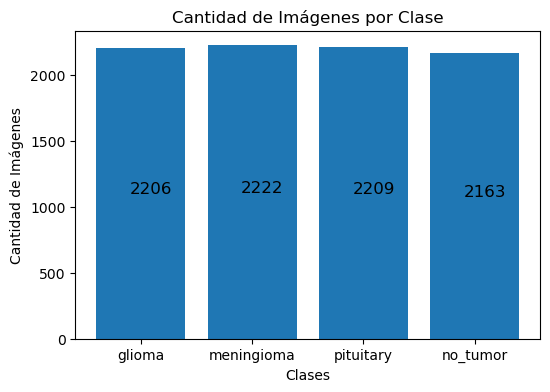

In [56]:
mostrar_grafico_clases(etiquetas_entrenamiento)

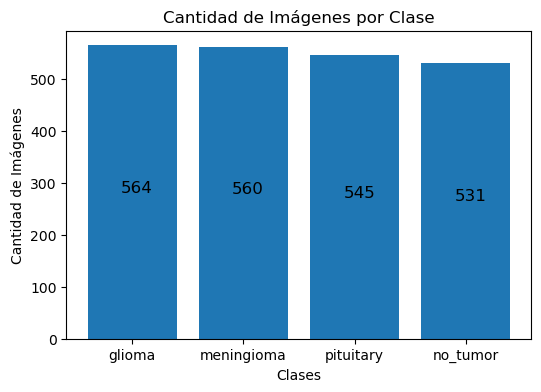

In [57]:
mostrar_grafico_clases(etiquetas_prueba)

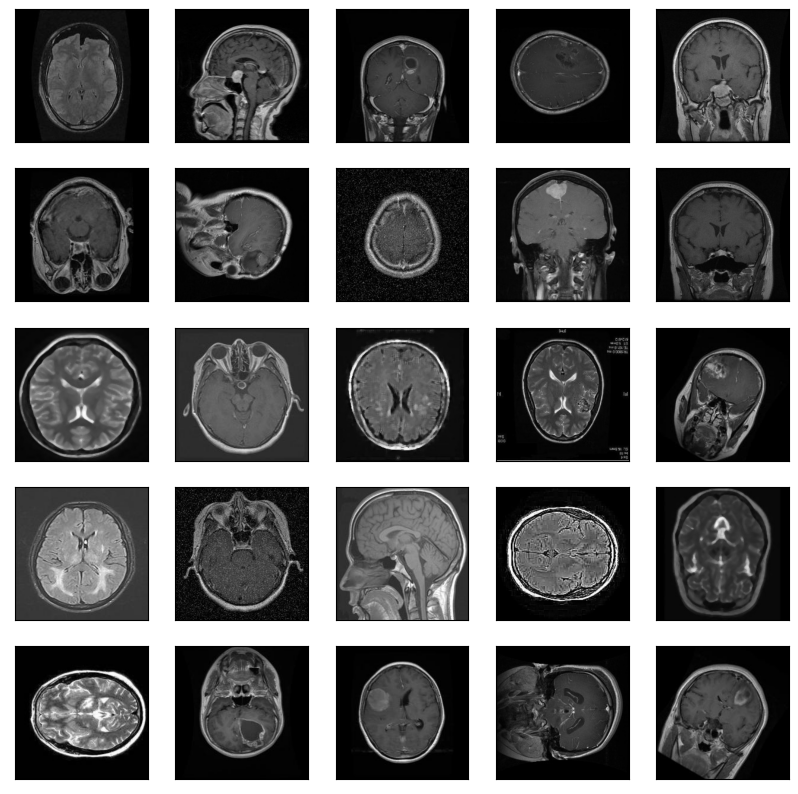

In [58]:
plt.figure(figsize = (10, 10))

for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(imagenes_entrenamiento[i])

plt.show()

In [59]:
# Normalización de entradas y conversión de listas a tensores
imagenes_entrenamiento = np.array(imagenes_entrenamiento).astype(float) / 255
imagenes_prueba = np.array(imagenes_prueba).astype(float) / 255

etiquetas_entrenamiento = np.array(etiquetas_entrenamiento)
etiquetas_prueba = np.array(etiquetas_prueba)

In [80]:
base_model = tf.keras.applications.EfficientNetV2S(
    include_top=False,
    weights="imagenet",
    input_shape=(224, 224, 3),
)

base_model.trainable = False

num_classes = 4
x = layers.GlobalAveragePooling2D()(base_model.output)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.5)(x)
output = layers.Dense(num_classes, activation='sigmoid')(x)

# Crear el modelo final
model = Model(inputs=base_model.input, outputs=output)

In [81]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [82]:
historial = model.fit(imagenes_entrenamiento, etiquetas_entrenamiento, epochs=20, validation_data=(imagenes_prueba, etiquetas_prueba))

Epoch 1/20
275/275 [==============================] - 325s 1s/step - loss: 0.4750 - accuracy: 0.5018 - val_loss: 0.4202 - val_accuracy: 0.6014
Epoch 2/20
275/275 [==============================] - 309s 1s/step - loss: 0.4344 - accuracy: 0.5624 - val_loss: 0.3880 - val_accuracy: 0.6450
Epoch 3/20
275/275 [==============================] - 311s 1s/step - loss: 0.4179 - accuracy: 0.5847 - val_loss: 0.3698 - val_accuracy: 0.6641
Epoch 4/20
275/275 [==============================] - 311s 1s/step - loss: 0.4054 - accuracy: 0.6080 - val_loss: 0.3613 - val_accuracy: 0.6805
Epoch 5/20
275/275 [==============================] - 311s 1s/step - loss: 0.3967 - accuracy: 0.6133 - val_loss: 0.3589 - val_accuracy: 0.6623
Epoch 6/20
275/275 [==============================] - 311s 1s/step - loss: 0.3901 - accuracy: 0.6252 - val_loss: 0.3481 - val_accuracy: 0.6964
Epoch 7/20
275/275 [==============================] - 312s 1s/step - loss: 0.3848 - accuracy: 0.6295 - val_loss: 0.3456 - val_accuracy: 0.6918

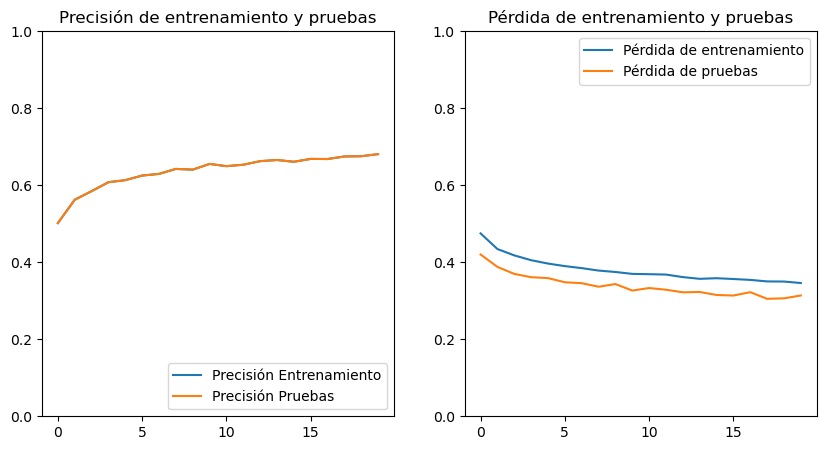

In [83]:
# Graficas de precisión y pérdida del modelo
acc = historial.history['accuracy']
val_acc = historial.history['accuracy']

loss = historial.history['loss']
val_loss = historial.history['val_loss']

rango_epocas = range(20)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(rango_epocas, acc, label='Precisión Entrenamiento')
plt.plot(rango_epocas, val_acc, label='Precisión Pruebas')
plt.legend(loc='lower right')
plt.ylim(0, 1)
plt.title('Precisión de entrenamiento y pruebas')

plt.subplot(1,2,2)
plt.plot(rango_epocas, loss, label= 'Pérdida de entrenamiento')
plt.plot(rango_epocas, val_loss, label='Pérdida de pruebas')
plt.legend(loc='upper right')
plt.ylim(0, 1)
plt.title('Pérdida de entrenamiento y pruebas')
plt.show()